In [ ]:
#!git clone https://github.com/bat67/TibetanMNIST.git

In [2]:
import os
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
#using tensor metrics instead of numpy arrays
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassCohenKappa, MulticlassAUROC, MulticlassConfusionMatrix
from torchvision import transforms
from torch import optim, nn, utils, Tensor
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import lightning as L
from lightning.pytorch.loggers import CSVLogger

In [3]:
data = np.load('TibetanMNIST/Datasets/TibetanMNIST.npz')

In [4]:
#Check labels where not null
# Access the labels
labels = data['label']

# Create a boolean mask for labels that are not equal to 0
mask = labels != 0

# Filter the labels and corresponding images
filtered_labels = labels[mask]
filtered_images = data['image'][mask]

# Print the filtered labels
print("Filtered Labels:", filtered_labels)

images = data['image']
labels = data['label']

Filtered Labels: [1 1 1 ... 9 9 9]


In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_path):
        # Load the data
        data = np.load(data_path)
        print(f"Available keys in the .npz file: {data.files}")

        # Define class objects
        self.images = data['image']
        self.labels = data['label']

        # Debugging: Check shapes and values
        print(f"Shape of images: {self.images.shape}")
        print(f"Shape of labels: {self.labels.shape}")
        print(f"Unique labels: {np.unique(self.labels)}")  # Check unique values in labels

    def __len__(self):
        # Define number of samples
        return len(self.labels)

    def __getitem__(self, idx):
        # Define feature and target
        x_temp = self.images[idx]
        y_temp1 = self.labels[idx]

        # Convert to torch tensors
        x = torch.tensor(x_temp, dtype=torch.float32).unsqueeze(0)
        #I also have to unsqueeze zero because otherwise it converts the numpy array values into torch index values and fills torch tensors with zeros
        #y_temp2 = torch.tensor(y_temp1, dtype=torch.int64).unsqueeze(0)
        #Now I can flatten it again into 1-D what the model expects
        #y = torch.flatten(y_temp2)[0]
        y = torch.tensor(y_temp1, dtype=torch.int64)

        return x, y

In [6]:
# Load Dataset
dataset = CustomDataset('TibetanMNIST/Datasets/TibetanMNIST.npz')

Available keys in the .npz file: ['image', 'label']
Shape of images: (17768, 28, 28)
Shape of labels: (17768,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


In [7]:
# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))    # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
# Define model params
class TibetanMNIST(L.LightningModule):
    def __init__(self, train_loader, val_loader, test_loader, hidden_size: int = 64, learning_rate: float = 2e-4):
        super().__init__()

        # Set our init args as class attributes
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims

        # Define PyTorch model ==>Wahrscheinlich liegt es an dem Model, weil es numpy arrays erwartet?
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )
        # Defining the tensor metrics from the torch library
        self.val_accuracy = MulticlassAccuracy(num_classes=self.num_classes)
        self.val_precision_metrics = MulticlassPrecision(num_classes=self.num_classes)
        self.val_recall_metrics = MulticlassRecall(num_classes=self.num_classes)
        self.val_auroc_metrics = MulticlassAUROC(num_classes=self.num_classes)
        self.val_confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes, normalize=None)
        self.val_f1_metrics = MulticlassF1Score(num_classes=self.num_classes)
        self.val_cohen_kappa_metrics = MulticlassCohenKappa(num_classes=self.num_classes)

        self.test_accuracy = MulticlassAccuracy(num_classes=self.num_classes)
        self.test_precision_metrics = MulticlassPrecision(num_classes=self.num_classes)
        self.test_recall_metrics = MulticlassRecall(num_classes=self.num_classes)
        self.test_auroc_metrics = MulticlassAUROC(num_classes=self.num_classes)
        self.test_confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes, normalize=None)
        self.test_f1_metrics = MulticlassF1Score(num_classes=self.num_classes)
        self.test_cohen_kappa_metrics = MulticlassCohenKappa(num_classes=self.num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_nb: int) -> torch.Tensor:
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_nb: int) -> None:
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Update metrics inside `on_validation_batch_end`
        self.val_accuracy.update(preds, y)
        self.val_precision_metrics.update(preds, y)
        self.val_recall_metrics.update(preds, y)
        self.val_auroc_metrics.update(preds, y)
        self.val_confusion_matrix.update(preds, y)
        self.val_f1_metrics.update(preds, y)
        self.val_cohen_kappa_metrics.update(preds, y)

        # logging
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        self.log("val_precision", self.val_precision_metrics, prog_bar=True)
        self.log("val_recall", self.val_recall_metrics, prog_bar=True)
        self.log("val_auroc", self.val_auroc_metrics, prog_bar=True)
        # Lightning's progress bar expects single scalar values for logging which is not applicable for confusion matrices
        self.log("val_confusion_matrix", self.val_confusion_matrix, prog_bar=False, on_epoch=False, on_step=True)
        self.log("val_f1", self.val_f1_metrics, prog_bar=True)
        self.log("val_cohen_kappa", self.val_cohen_kappa_metrics, prog_bar=True)

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_nb: int) -> None:
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Update metrics inside on_test_batch_end
        self.test_accuracy.update(preds, y)
        self.test_accuracy.update(preds, y)
        self.test_precision_metrics.update(preds, y)
        self.test_recall_metrics.update(preds, y)
        self.test_auroc_metrics.update(preds, y)
        self.test_confusion_matrix.update(preds, y)
        self.test_f1_metrics.update(preds, y)
        self.test_cohen_kappa_metrics.update(preds, y)

        # logging
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        self.log("test_precision", self.test_precision_metrics, prog_bar=True)
        self.log("test_recall", self.test_recall_metrics, prog_bar=True)
        self.log("test_auroc", self.test_auroc_metrics, prog_bar=True)
        self.log("test_confusion_matrix", self.test_confusion_matrix, prog_bar=False, on_epoch=False, on_step=True)
        self.log("test_f1", self.test_f1_metrics, prog_bar=True)
        self.log("test_cohen_kappa", self.test_cohen_kappa_metrics, prog_bar=True)

    def configure_optimizers(self) -> torch.optim.Optimizer:
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader

    def test_dataloader(self):
        return test_loader

In [9]:
#Simple model
class SimpleTibetanNumberClassifier(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.l1 = torch.nn.Linear(28 * 28, num_classes)
        
        # Defining the tensor metrics from the torch library
        self.val_accuracy = MulticlassAccuracy(num_classes=self.num_classes)
        self.val_precision_metrics = MulticlassPrecision(num_classes=self.num_classes)
        self.val_recall_metrics = MulticlassRecall(num_classes=self.num_classes)
        self.val_auroc_metrics = MulticlassAUROC(num_classes=self.num_classes)
        self.val_confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes, normalize=None)
        self.val_f1_metrics = MulticlassF1Score(num_classes=self.num_classes)
        self.val_cohen_kappa_metrics = MulticlassCohenKappa(num_classes=self.num_classes)
        
        # Test metrics
        self.test_accuracy = MulticlassAccuracy(num_classes=self.num_classes)
        self.test_precision_metrics = MulticlassPrecision(num_classes=self.num_classes)
        self.test_recall_metrics = MulticlassRecall(num_classes=self.num_classes)
        self.test_auroc_metrics = MulticlassAUROC(num_classes=self.num_classes)
        self.test_confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes, normalize=None)
        self.test_f1_metrics = MulticlassF1Score(num_classes=self.num_classes)
        self.test_cohen_kappa_metrics = MulticlassCohenKappa(num_classes=self.num_classes)


    def forward(self, x):
        return self.l1(x.view(x.size(0), -1))

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)  # Use cross_entropy for classification
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        #preds = torch.argmax(logits, dim=1)
        preds = torch.softmax(logits, dim=1)
        # Update metrics inside `on_validation_batch_end`
        self.val_accuracy.update(preds, y)
        self.val_precision_metrics.update(preds, y)
        self.val_recall_metrics.update(preds, y)
        self.val_auroc_metrics.update(preds, y)
        self.val_confusion_matrix.update(preds, y)
        self.val_f1_metrics.update(preds, y)
        self.val_cohen_kappa_metrics.update(preds, y)

        # logging
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        self.log("val_precision", self.val_precision_metrics, prog_bar=True)
        self.log("val_recall", self.val_recall_metrics, prog_bar=True)
        self.log("val_auroc", self.val_auroc_metrics, prog_bar=True)
        # Lightning's progress bar expects single scalar values for logging which is not applicable for confusion matrices
        self.log("val_confusion_matrix", self.val_confusion_matrix, prog_bar=False, on_epoch=False, on_step=True)
        self.log("val_f1", self.val_f1_metrics, prog_bar=True)
        self.log("val_cohen_kappa", self.val_cohen_kappa_metrics, prog_bar=True)
        
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.softmax(logits, dim=1)
    
        # Update test metrics
        self.test_accuracy.update(preds, y)
        self.test_precision_metrics.update(preds, y)
        self.test_recall_metrics.update(preds, y)
        self.test_auroc_metrics.update(preds, y)
        self.test_confusion_matrix.update(preds, y)
        self.test_f1_metrics.update(preds, y)
        self.test_cohen_kappa_metrics.update(preds, y)
    
        # Log test metrics
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        self.log("test_precision", self.test_precision_metrics, prog_bar=True)
        self.log("test_recall", self.test_recall_metrics, prog_bar=True)
        self.log("test_auroc", self.test_auroc_metrics, prog_bar=True)
        self.log("test_confusion_matrix", self.test_confusion_matrix, prog_bar=False, on_epoch=True, on_step=False)
        self.log("test_f1", self.test_f1_metrics, prog_bar=True)
        self.log("test_cohen_kappa", self.test_cohen_kappa_metrics, prog_bar=True)
    
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [10]:
# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.3 * len(dataset))    # 15% for validation
#test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

#train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# Initialize the model
#model = TibetanMNIST(train_loader, val_loader, test_loader)
model = SimpleTibetanNumberClassifier()

In [12]:
# train with both splits (simple model)
trainer = L.Trainer(max_epochs=10, logger=CSVLogger(save_dir="csv_logs", name="TibetanMNIST"))
trainer.fit(model, train_loader, val_loader,)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                     | Type                      | Params | Mode 
--------------------------------------------------------------------------------
0  | l1                       | Linear                    | 7.9 K  | train
1  | val_accuracy             | MulticlassAccuracy        | 0      | train
2  | val_precision_metrics    | MulticlassPrecision       | 0      | train
3  | val_recall_metrics       | MulticlassRecall          | 0      | train
4  | val_auroc_metrics        | MulticlassAUROC           | 0      | train
5  | val_confusion_matrix     | MulticlassConfusionMatrix | 0      | train
6  | val_f1_metrics           | MulticlassF1Score         | 0      | train
7  | val_cohen_kappa_metrics  | MulticlassCohenKappa      | 0      | train
8  | test_accuracy            | MulticlassAccuracy        | 0      | train
9  | test_precision_metrics   | MulticlassPrecision  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/TibetanLayoutAnalyzer/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/TibetanLayoutAnalyzer/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/opt/anaconda3/envs/TibetanLayoutAnalyzer/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [13]:
# After training, run the test step to get predictions and true labels
trainer.test(model=model, dataloaders=test_loader)

/opt/anaconda3/envs/TibetanLayoutAnalyzer/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

ValueError: The metric `tensor([[288,   3,   0,   0,   0,   0,   0,   0,   0,   0],
        [  3, 320,   0,   0,   0,   0,   0,   0,   0,   1],
        [  2,   3, 236,  14,   1,   0,   0,   0,   0,   2],
        [  0,   1,  32, 224,   1,   0,   1,   2,   2,   6],
        [  1,   0,   0,   2, 287,   0,   1,   2,   1,  21],
        [  0,   0,   0,   0,   7, 184,   0,   5,   0,   3],
        [  0,   0,   0,   0,   3,   4, 223,   3,   0,   0],
        [  0,   0,   0,   2,   4,   1,   7, 189,   2,   0],
        [  0,   0,   0,   1,   8,   2,   0,   3, 244,   0],
        [  0,   1,   0,   0,  12,   0,   1,   1,   0, 299]], device='mps:0')` does not contain a single element, thus it cannot be converted to a scalar.

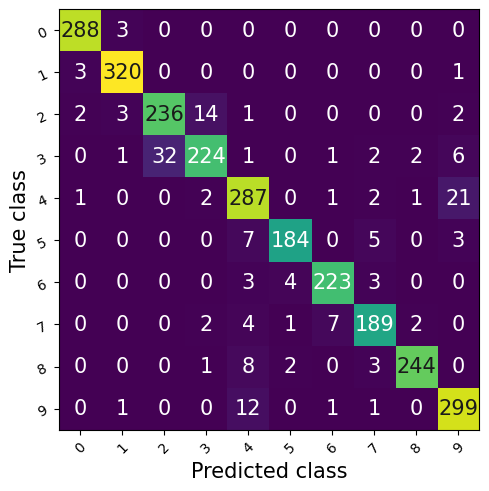

In [14]:
#plot the confusion matrix
model.test_confusion_matrix.plot()
plt.show()